In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import *
from random import *
import csv

%matplotlib inline

/home/gadorlhiac/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Sets Common Settings (e.g. pixel number) 

In [2]:
# Pixels
num_pix = 300
pix = np.linspace(0, 300, num_pix)

# Time Points
num_t = 100
times = np.zeros([num_t])
times[1:] = np.logspace(-1, 3.5, num_t - 1)

In [3]:
# Species Associated Spectra
E_1 = np.array(map(lambda x: 3*exp(-(x-100)**2/(2500)) + exp(-(x-150)**2/(2*700)) + exp(-(x-280)**2/(2*700)), pix))
E_2 = np.array(map(lambda x: 4*exp(-(x-50)**2/(2*450)) + exp(-(x-170)**2/(2*700)), pix))
E_3 = np.array(map(lambda x: 3*exp(-(x-250)**2/(2*500)) + exp(-(x-220)**2/(2*100)) + exp(-(x-200)**2/(2*60)), pix))
E_4 = np.array(map(lambda x: 1.5*exp(-(x-280)**2/(2*100)) + 2*exp(-(x-300)**2/(2*30)), pix))
E_5 = np.array(map(lambda x: 2.5*exp(-(x-10)**2/(2*300)) + 2*exp(-(x-40)**2/(2*30)), pix))

# Dynamically Moving Band

In [4]:
C_dyn = np.zeros([num_t, 1])
C_dyn[0, :] = [1]

# Moving band -- store the spectra at different time points
dynE = np.zeros([num_t, num_pix])
dynE[0, :] = E_1

# Calculate concentrations
for i in range(1, num_t):
    k0 = 1./100
    C_dyn[i, 0] = C_dyn[i-1, 0] - k0*C_dyn[i-1, 0]*(times[i]-times[i-1])
    if i < 15:
        dynE[i, :] = map(lambda x: 3*exp(-(x-100-3*i)**2/(2500)) + exp(-(x-150-3*i)**2/(2*700)) + exp(-(x-280-3*i)**2/(2*700)), pix)
    else:
        dynE[i, :] = dynE[i-1, :]
        
    if C_dyn[i, 0] < 0:
        C_dyn[i, 0] = 0

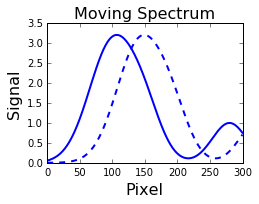

In [5]:
plt.figure(figsize=(3.5, 2.5))
plt.title('Moving Spectrum', fontsize=16)
plt.xlabel('Pixel', fontsize=16)
plt.ylabel('Signal', fontsize=16)
plt.plot(pix, dynE[0], 'b', linewidth=2)
plt.plot(pix, dynE[23], 'b--', linewidth=2)

In [6]:
data_dyn = np.zeros([num_t, num_pix])
data_dyn_noise = np.zeros([num_t, num_pix])

# Generate data -- each species concentration times its spectrum
for t in range(len(times)):
    data_dyn[t, :] = C_dyn[t, 0]*dynE[t, :]

# Add noise
m = np.amax(data_dyn)
for t in range(len(times)):
    data_dyn_noise[t, :] = data_dyn[t, :] + (np.tile(-1, num_pix) + 2*np.random.rand(num_pix))*(.1*m)
    
data_dyn = np.nan_to_num(data_dyn)
data_dyn_noise = np.nan_to_num(data_dyn_noise)

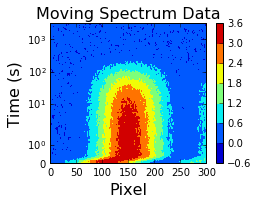

In [7]:
plt.figure(figsize=(3.5, 2.5))
plt.contourf(pix,times,data_dyn_noise)
plt.colorbar()
plt.xlabel('Pixel', fontsize=16)
plt.title('Moving Spectrum Data', fontsize=16)
plt.ylabel('Time (s)', fontsize=16)
plt.yscale('symlog')
#plt.savefig('dynamic.svg')

In [59]:
# Write files out
out = np.zeros([num_t + 1, num_pix + 1])
out[0, 1:] = pix
out[1:, 0] = times
out[1:, 1:] = data_dyn
out = out.tolist()
with open('../dynamic.csv', 'w') as f:
    wr = csv.writer(f)
    wr.writerows(out)

out = np.array(out)
out[1:, 1:] = data_dyn_noise
out = out.tolist()
with open('../dynamic_noise10.csv', 'w') as f:
    wr = csv.writer(f)
    wr.writerows(out)

# Heterogenous Decay Lifetimes

In [46]:
C_het = np.zeros([num_t, 3])
C_het[0, :] = [1, 0, 0]

for i in range(1, num_t):
    k0 = np.random.choice(np.array([1./8, 1./20, 1./50]), size=1)
    k1 = np.random.choice(np.array([1./30, 1./60, 1./100]), size=1)
    k2 = np.random.choice(np.array([1./500, 1./1000, 1./2000]), size=1)
    
    
    C_het[i, 0] = C_het[i-1, 0] - k0*C_het[i-1, 0]*(times[i]-times[i-1])
    C_het[i, 1] = C_het[i-1, 1] + (k0*C_het[i-1, 0] - k1*C_het[i-1, 1])*(times[i]-times[i-1])
    C_het[i, 2] = C_het[i-1, 2] + (k1*C_het[i-1, 1] - k2*C_het[i-1, 2])*(times[i]-times[i-1])
    if C_het[i, 0] < 0:
        C_het[i, 0] = 0
        
    if C_het[i, 1] < 0:
        C_het[i, 1] = 0
        
    if C_het[i, 2] < 0:
        C_het[i, 2] = 0

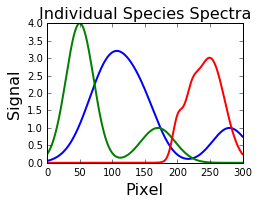

In [47]:
plt.figure(figsize=(3.5, 2.5))
plt.plot(pix, E_1, label='A', linewidth=2)
plt.plot(pix, E_2, label='B', linewidth=2)
plt.plot(pix, E_3, label='C', linewidth=2)
plt.title('Individual Species Spectra', fontsize=16)
plt.xlabel('Pixel', fontsize=16)
plt.ylabel('Signal', fontsize=16)

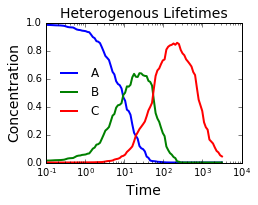

In [38]:
plt.figure(figsize=(3.5, 2.5))
for i in range(3):
    plt.plot(times,C_het[:,i],label="ABC"[i], linewidth=2)
    plt.xscale('log')
    plt.title('Heterogenous Lifetimes', fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Concentration', fontsize=14)
    plt.legend(loc=0, frameon=False)

In [48]:
data_het = np.zeros([num_t, num_pix])
data_het_noise = np.zeros([num_t, num_pix])
for t in range(len(times)):
    data_het[t, :] = C_het[t, 0]*E_1 + C_het[t, 1]*E_2 + C_het[t, 2]*E_3
    
m = np.amax(data_het)
for t in range(len(times)):
    data_het_noise[t, :] = data_het[t, :] + (np.tile(-1, num_pix) + 2*np.random.rand(num_pix))*(.1*m)
    
data_het = np.nan_to_num(data_het)
data_het_noise = np.nan_to_num(data_het_noise)

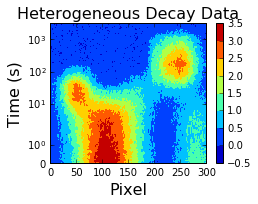

In [50]:
plt.figure(figsize=(3.5, 2.5))
plt.contourf(pix,times,data_het_noise)
plt.colorbar()
plt.xlabel('Pixel', fontsize=16)
plt.title('Heterogeneous Decay Data', fontsize=16)
plt.ylabel('Time (s)', fontsize=16)
plt.yscale('symlog')
plt.savefig('hettaus.svg')

In [40]:
out = np.array(out)
out[1:, 1:] = data_het
out = out.tolist()
with open('../hettaus.csv', 'w') as f:
    wr = csv.writer(f)
    wr.writerows(out)
    
out = np.array(out)
out[1:, 1:] = data_het_noise
out = out.tolist()
with open('../hettaus_noise10.csv', 'w') as f:
    wr = csv.writer(f)
    wr.writerows(out)

# Full data set

In [51]:
C_full = np.zeros([num_t, 5])
C_full[0, :] = [1, 0, 0, 0, 0]

In [52]:
for i in range(1, num_t):
    k0 = np.random.choice(np.array([1./3, 1./8, 1./10]), size=1)
    k1 = np.random.choice(np.array([1./8, 1./12, 1./20]), size=1)
    k2 = np.random.choice(np.array([1./30, 1./60, 1./100]), size=1)
    k3 = np.random.choice(np.array([1./150, 1./200, 1./250]), size=1)
    k4 = np.random.choice(np.array([1./3000, 1./3500, 1./4000]), size=1)

    C_full[i, 0] = C_full[i-1, 0] - k0*C_full[i-1, 0]*(times[i]-times[i-1])
    C_full[i, 1] = C_full[i-1, 1] + (k0*C_full[i-1, 0] - k1*C_full[i-1, 1])*(times[i]-times[i-1])
    C_full[i, 2] = C_full[i-1, 2] + (k1*C_full[i-1, 1] - k2*C_full[i-1, 2])*(times[i]-times[i-1])
    C_full[i, 3] = C_full[i-1, 3] + (k2*C_full[i-1, 2] - k3*C_full[i-1, 3])*(times[i]-times[i-1])
    C_full[i, 4] = C_full[i-1, 4] + (k3*C_full[i-1, 3] - k4*C_full[i-1, 4])*(times[i]-times[i-1])
    if C_full[i, 0] < 0:
        C_full[i, 0] = 0
        
    if C_full[i, 1] < 0:
        C_full[i, 1] = 0
        
    if C_full[i, 2] < 0:
        C_full[i, 2] = 0
        
    if C_full[i, 3] < 0:
        C_full[i, 3] = 0
        
    if C_full[i, 4] < 0:
        C_full[i, 4] = 0

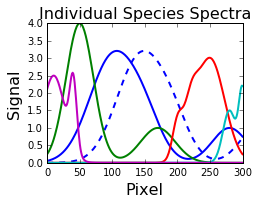

In [54]:
plt.figure(figsize=(3.5, 2.5))
plt.plot(pix, E_1, label='A', linewidth=2)
plt.plot(pix, dynE[23], label='A', linewidth=2, linestyle='--', color='blue')
plt.plot(pix, E_2, label='B', linewidth=2)
plt.plot(pix, E_3, label='C', linewidth=2)
plt.plot(pix, E_4, label='D', linewidth=2)
plt.plot(pix, E_5, label='E', linewidth=2)
plt.title('Individual Species Spectra', fontsize=16)
plt.xlabel('Pixel', fontsize=16)
plt.ylabel('Signal', fontsize=16)

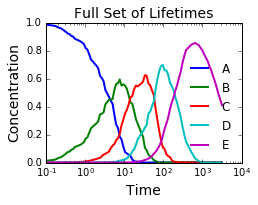

In [44]:
plt.figure(figsize=(3.5, 2.5))
for i in range(5):
    plt.plot(times, C_full[:,i],label="ABCDE"[i], linewidth=2)
    plt.xscale('log')
    plt.title('Full Set of Lifetimes', fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Concentration', fontsize=14)
    plt.legend(loc=0, frameon=False)

In [55]:
data_full = np.zeros([num_t, num_pix])
data_full_noise = np.zeros([num_t, num_pix])
for t in range(len(times)):
    data_full[t, :] = C_full[t, 0]*dynE[t, :] + C_full[t, 1]*E_2 + C_full[t, 2]*E_3 + C_full[t, 3]*E_4 + C_full[t, 4]*E_5
    
m = np.amax(data_full)
for t in range(len(times)):
    data_full_noise[t, :] = data_full[t, :] + (np.tile(-1, num_pix) + 2*np.random.rand(num_pix))*(.1*m)
    
data_full = np.nan_to_num(data_full)
data_full_noise = np.nan_to_num(data_full_noise)

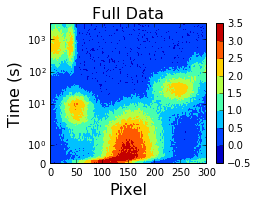

In [57]:
plt.figure(figsize=(3.5, 2.5))
plt.contourf(pix,times,data_full_noise)
plt.colorbar()
plt.xlabel('Pixel', fontsize=16)
plt.title('Full Data', fontsize=16)
plt.ylabel('Time (s)', fontsize=16)
plt.yscale('symlog')

In [58]:
out = np.array(out)
out[1:, 1:] = data_full
out = out.tolist()
with open('../fulldata.csv', 'w') as f:
    wr = csv.writer(f)
    wr.writerows(out)

out = np.array(out)
out[1:, 1:] = data_full_noise
out = out.tolist()
with open('../fulldata_noise10.csv', 'w') as f:
    wr = csv.writer(f)
    wr.writerows(out)